In [1]:
# Predict dog breed from image

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

import numpy as np
print("GPU is", "available" if torch.cuda.is_available() else "NOT AVAILABLE")
print(torch.__version__)

GPU is available
1.5.1


In [2]:
# import images dataset
import os
from PIL import Image
#import cv2


BATCH_SIZE = 32
IMG_SIZE = (300, 300)

#dataset_description_path = "C:\Users\Drake Li\Desktop\cwd\ds-stuff\data\list.txt"
dataset_path = "./data/cat-dog-images"
labels_path = "./dog-breed-classes.json"

#Image CLASS-ID SPECIES BREED ID
#ID: 1:37 Class ids
#SPECIES: 1:Cat 2:Dog
#BREED ID: 1-25:Cat 1:12:Dog
#All images with 1st letter as captial are cat images
#images with small first letter are dog images

# load dataset

In [3]:
import random
dataset=[]

classes = {}
labelcounter=0
    
for i,fn in enumerate(os.listdir(dataset_path)):
    if(fn.endswith(".mat")):#skip those
        continue
    if(fn[0].isupper()):
        #cat
        #print("cat")
        pass
    else:
        #dog
        #print(fn)
        
        breed_name =fn[:fn.rfind("_")]#from rule
        
        
        #labels.append(breed_name)
        img_bytes = Image.open(os.path.join(dataset_path,fn))
        img = torchvision.transforms.functional.resize(img=img_bytes,size=IMG_SIZE)#resize img
        img=(np.array(img)/255.0).astype(np.float32)
        #should be [300,300,3]
        if(img.shape != (300,300,3)):
            #skip some black-white image or non-standard rgb image
            continue
            
        c = breed_name
        #print(c)
        if(c not in classes):
            #new breed label
            classes[c]=labelcounter
            labelcounter+=1
        dataset.append([img,classes[c]])


        
    
print(classes)


print("dataset size:{}".format(len(dataset)))     #3670
train_size=int(len(dataset)*0.8)
test_size=len(dataset)-train_size

#remember to shuffle
random.shuffle(dataset)
#doesn't hurt to shuffle again
trainloader = torch.utils.data.DataLoader(dataset[:train_size], shuffle=True, batch_size=BATCH_SIZE)
testloader = torch.utils.data.DataLoader(dataset[train_size:], shuffle=True, batch_size=BATCH_SIZE)
print("loaded data.")


{'american_bulldog': 0, 'american_pit_bull_terrier': 1, 'basset_hound': 2, 'beagle': 3, 'boxer': 4, 'chihuahua': 5, 'english_cocker_spaniel': 6, 'english_setter': 7, 'german_shorthaired': 8, 'great_pyrenees': 9, 'havanese': 10, 'japanese_chin': 11, 'keeshond': 12, 'leonberger': 13, 'miniature_pinscher': 14, 'newfoundland': 15, 'pomeranian': 16, 'pug': 17, 'saint_bernard': 18, 'samoyed': 19, 'scottish_terrier': 20, 'shiba_inu': 21, 'staffordshire_bull_terrier': 22, 'wheaten_terrier': 23, 'yorkshire_terrier': 24}
dataset size:4988
loaded data.


In [4]:
#import json
#save everything here
# with open(labels_path,"w") as fp1:
#     json.dump(classes,fp1)
# print("Labels saved to files.")

rows=5,cols=5


<Figure size 1500x1500 with 0 Axes>

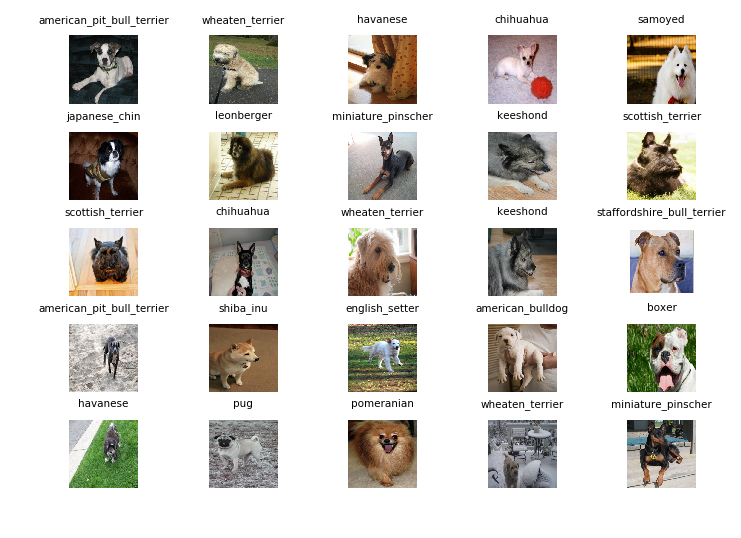

In [5]:
# plot some of the images
import matplotlib.pyplot as plt
import random
import math
import json
import utils
random.seed(233)

    
with open(labels_path,"r") as fp1:
    classes = json.load(fp1)
    classes = {k:int(v) for k,v in classes.items()}
    classes_rev = {int(v):k for k,v in classes.items()}
        

plt.rcParams['figure.dpi'] = 150




subset = random.sample(dataset,25)
utils.show_imgs(data=[item[0] for item in subset],real_labels=[item[1] for item in subset],classes_rev=classes_rev)



In [79]:
import torchvision.models as models
from torchsummary import summary
vgg16 = models.vgg16(pretrained=True)

for param in vgg16.parameters():
    #print(param)
    param.requires_grad = False

vgg16.classifier[-1] = nn.Linear(in_features=4096, out_features=len(classes))
# vgg16.classifier. torch.nn.Softmax
print(vgg16)

#vgg16.cuda()    #move it to cuda
#summary(vgg16, (3, 300, 300))


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [80]:
#take a look of example input-output of mdel
## compute accuracy
def get_accuracy(logit, target, batch_size):
    ''' Obtain accuracy for training round '''
    # torch.max[0] stores the data, torch.max[1] stores the index (of the max)
    corrects = (torch.max(logit, 1)[1].view(target.size()).data == target.data).sum()
    accuracy = 100.0 * corrects/batch_size
    return accuracy.item()

for images, labels in trainloader:
    b = images.permute(0,3,1,2)#rearrange shape
    print(b.shape)
    
    out = vgg16(b)
    print("batch size:", images.shape)
    print(out.shape)
    acc = get_accuracy(out,labels,BATCH_SIZE)
    
    #out[i] is array[5] with probability; labels[i] is ground truth
    #use max of out[i] as prediction
    print("{},{}".format(out[0],labels[0]))
    break
def freeze_model(model):
    for param in model.parameters():
        param.requires_grad = False
    return
# for images, labels in trainloader:
#     pass
for images, labels in testloader:
    pass
print("ok")

torch.Size([32, 3, 300, 300])
batch size: torch.Size([32, 300, 300, 3])
torch.Size([32, 25])
tensor([-0.0081,  0.1641,  0.5410, -0.4622,  0.0512, -0.2831,  1.3702, -0.0267,
        -0.0585,  0.4180,  0.2549, -1.0617, -0.5503, -0.3867, -0.0303,  0.6976,
         0.1767, -0.6309, -0.6695, -0.2789,  0.2188, -0.3521,  0.2296, -0.3535,
        -0.1360], grad_fn=<SelectBackward>),20
ok


In [81]:
#start training
import torch.optim as optim

learning_rate = 0.01
num_epochs=20

criterion = nn.CrossEntropyLoss() 
optimizer = optim.SGD(vgg16.classifier[-1].parameters(),lr=learning_rate,momentum=0.9)



In [82]:
res=[]
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
vgg16.to(device)
for epoch in range(num_epochs):
    train_running_loss = 0.0
    train_acc = 0.0
    vgg16 = vgg16.train()
    for i, (images, labels) in enumerate(trainloader):
        images = images.to(device)
        labels = labels.to(device)
        b = images.permute(0,3,1,2)
        out = vgg16(b)
        loss = criterion(out, labels)
        optimizer.zero_grad()
        loss.backward()
        
        ## update model params
        optimizer.step()
        train_running_loss += loss.detach().item()      #make a copy without tracking it
        train_acc += get_accuracy(out, labels, BATCH_SIZE)#use += instead of =
    vgg16.eval()
    test_acc = 0.0
    for j, (images, labels) in enumerate(testloader):
        images = images.to(device)
        labels = labels.to(device)
        b = images.permute(0,3,1,2)
        outputs = vgg16(b)
        test_acc += get_accuracy(outputs, labels, BATCH_SIZE)
    
    print('Epoch: %d | Loss: %.4f | Train Accuracy: %.2f | Test Accuracy: %.2f' \
          %(epoch, train_running_loss / i, train_acc/i, test_acc/j ))#accumulated, so use += before
    res.append([learning_rate, epoch, train_running_loss / i, train_acc/i, test_acc/j])

freeze_model(vgg16)#freeze the model

cuda:0
Epoch: 0 | Loss: 0.9285 | Train Accuracy: 71.55 | Test Accuracy: 83.97
Epoch: 1 | Loss: 0.5668 | Train Accuracy: 82.59 | Test Accuracy: 83.67
Epoch: 2 | Loss: 0.5187 | Train Accuracy: 83.85 | Test Accuracy: 82.46
Epoch: 3 | Loss: 0.4808 | Train Accuracy: 84.07 | Test Accuracy: 84.68
Epoch: 4 | Loss: 0.3972 | Train Accuracy: 87.17 | Test Accuracy: 84.68
Epoch: 5 | Loss: 0.4205 | Train Accuracy: 86.49 | Test Accuracy: 86.90
Epoch: 6 | Loss: 0.3852 | Train Accuracy: 87.80 | Test Accuracy: 84.68
Epoch: 7 | Loss: 0.3670 | Train Accuracy: 87.95 | Test Accuracy: 85.89
Epoch: 8 | Loss: 0.3543 | Train Accuracy: 88.79 | Test Accuracy: 86.59
Epoch: 9 | Loss: 0.3717 | Train Accuracy: 88.41 | Test Accuracy: 86.09
Epoch: 10 | Loss: 0.3533 | Train Accuracy: 89.21 | Test Accuracy: 84.68
Epoch: 11 | Loss: 0.3162 | Train Accuracy: 89.74 | Test Accuracy: 85.28
Epoch: 12 | Loss: 0.3172 | Train Accuracy: 90.07 | Test Accuracy: 84.17
Epoch: 13 | Loss: 0.2877 | Train Accuracy: 90.80 | Test Accuracy: 8

model saved to ./dog_breed_vgg16.pth
torch.Size([25, 3, 300, 300])
[ 1  9 16 19 17 24 24  2  0 11  3  4 23 24 17 12  9  2 12 19 20 15 21  1
  8]
correct prediction:23/25
rows=5,cols=5


<Figure size 1500x1500 with 0 Axes>

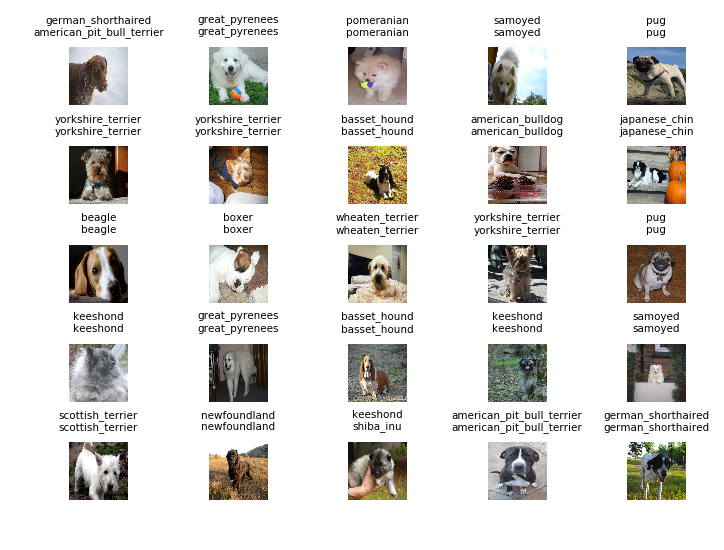

In [140]:
#evaluate in a visualized way
model_path = "./dog_breed_vgg16.pth"
torch.save(vgg16, model_path)
print("model saved to {}".format(model_path))
subset = random.sample(dataset,25)
imgs = np.asarray([item[0] for item in subset])
    #subset=np.append(subset,item[0])
imgs = torch.tensor(imgs)
imgs = imgs.to(device)
b = imgs.permute(0,3,1,2)

print(b.shape)
outputs = vgg16(b)
outputs = torch.max(outputs, 1)[1].data.cpu().numpy() #convert into array
print(outputs)
correct_num=0
for i in range(25):
    if(outputs[i] == subset[i][1]):
        correct_num+=1
print("correct prediction:{}/25".format(correct_num))
show_imgs(data=[item[0] for item in subset],real_labels=[item[1] for item in subset],pred_labels=outputs)

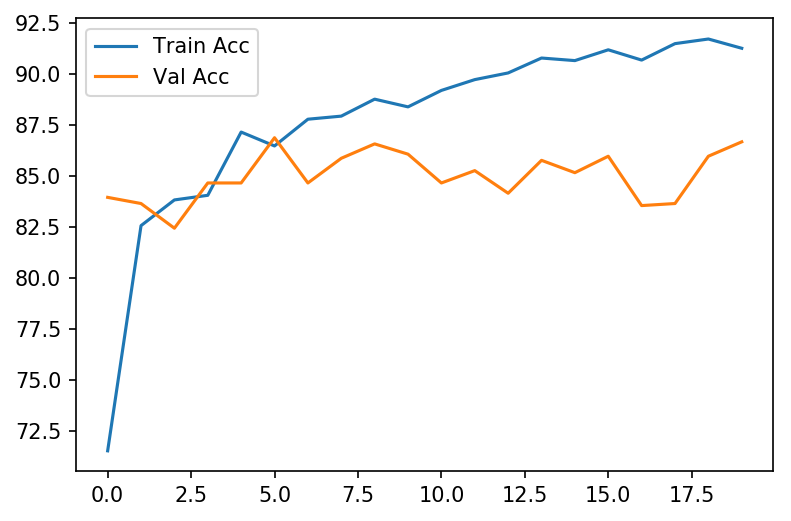

In [92]:
import pandas as pd
df = pd.DataFrame(res, columns = ["Learning Rate", "Epoch", "Train Loss", "Train Acc", "Val Acc"])
df[["Train Acc", "Val Acc"]].plot()

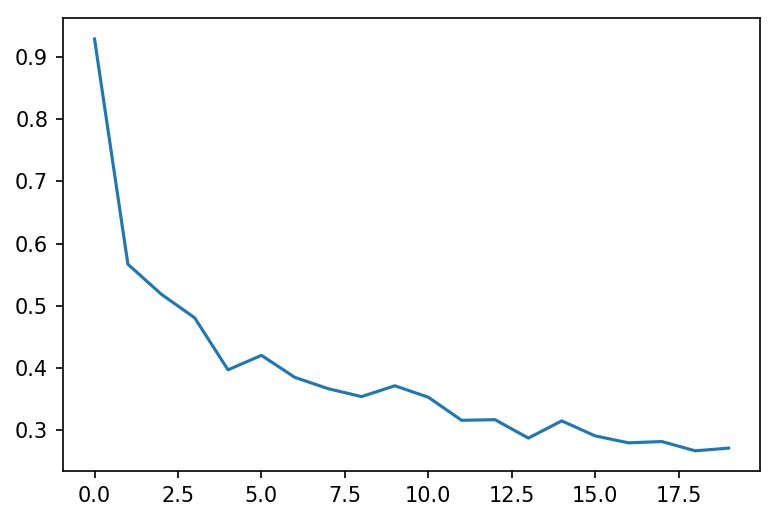

In [93]:
df["Train Loss"].plot()

{0: 'american_bulldog', 1: 'american_pit_bull_terrier', 2: 'basset_hound', 3: 'beagle', 4: 'boxer', 5: 'chihuahua', 6: 'english_cocker_spaniel', 7: 'english_setter', 8: 'german_shorthaired', 9: 'great_pyrenees', 10: 'havanese', 11: 'japanese_chin', 12: 'keeshond', 13: 'leonberger', 14: 'miniature_pinscher', 15: 'newfoundland', 16: 'pomeranian', 17: 'pug', 18: 'saint_bernard', 19: 'samoyed', 20: 'scottish_terrier', 21: 'shiba_inu', 22: 'staffordshire_bull_terrier', 23: 'wheaten_terrier', 24: 'yorkshire_terrier'}
torch.Size([2, 3, 300, 300])
[16 21]
rows=1,cols=2


<Figure size 1500x1500 with 0 Axes>

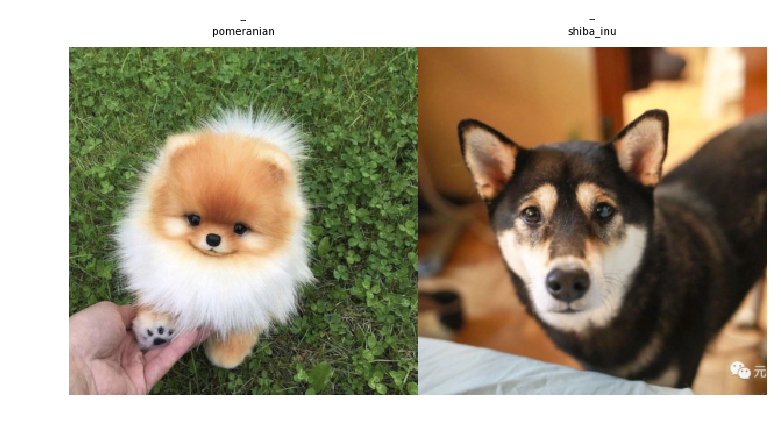

In [10]:
#same as use_models.ipynb
import torch
from PIL import Image
import torchvision
import numpy as np
import utils
import json
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
IMG_SIZE=(300,300)
vgg16 = torch.load('./dog_breed_vgg16.pth', map_location=torch.device(device))
with open("./dog-breed-classes.json","r") as fp1:
    classes = json.load(fp1)
    classes = {k:int(v) for k,v in classes.items()}
    classes_rev = {int(v):k for k,v in classes.items()}
print(classes_rev)
def recognize_img(img_paths):
    imgs=[]
    for img_path in img_paths:
        img_bytes = Image.open(img_path)
        img = torchvision.transforms.functional.resize(img=img_bytes,size=IMG_SIZE)#resize img
        img=(np.array(img)/255.0).astype(np.float32)
        imgs.append(img)
    imgs = np.asarray(imgs)
    #subset=np.append(subset,item[0])
    imgs_tensor = torch.tensor(imgs)
    imgs_tensor = imgs_tensor.to(device)
    b = imgs_tensor.permute(0,3,1,2)

    print(b.shape)
    outputs = vgg16(b)
    outputs = torch.max(outputs, 1)[1].data.cpu().numpy() #convert into array
    print(outputs)
    
    utils.show_imgs(imgs,real_labels=None,pred_labels=outputs,classes_rev=classes_rev)
    
img_paths = [r"C:\Users\Drake Li\Desktop\cwd\ds-stuff\data\etc_imgs\dog1.jpg",
             r"C:\Users\Drake Li\Desktop\cwd\ds-stuff\data\etc_imgs\dog2_cr.jpg",
            ]
recognize_img(img_paths)